In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(), transforms.Resize((64, 64)), transforms.ToTensor()]
)

In [15]:
train_data = datasets.ImageFolder("chest_Xray/train", transform=transform)
test_data = datasets.ImageFolder("chest_Xray/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
def dataset_to_numpy(loader):
    features, labels = [], []
    for images, label in loader:
        images = images.view(images.size(0), -1)
        features.append(images.numpy())
        labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels)


X_train, y_train = dataset_to_numpy(train_loader)
X_test, y_test = dataset_to_numpy(test_loader)

In [ ]:
pipeline = Pipeline([("pca", PCA(n_components=50)), ("clf", RandomForestClassifier())])

param_grid = {
    "clf__n_estimators": [100],
    "clf__max_depth": [10],
    "clf__min_samples_split": [5],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres : {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


Classification report:
               precision    recall  f1-score   support

           0       0.96      0.27      0.43       234
           1       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.62       624
weighted avg       0.79      0.72      0.67       624

Confusion matrix:
 [[ 64 170]
 [  3 387]]


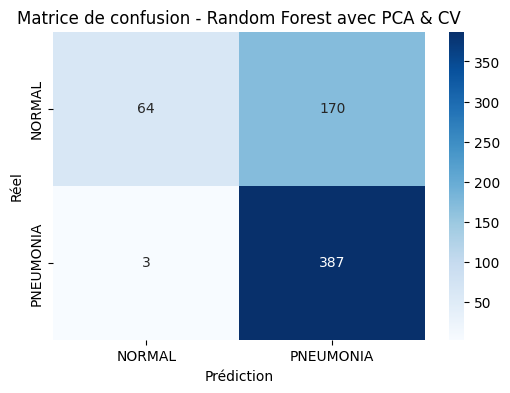

In [ ]:
y_pred = grid_search.predict(X_test)

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_data.classes,
    yticklabels=train_data.classes,
)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Random Forest avec PCA & CV")
plt.show()

In [ ]:
import pandas as pd

# Convert classification report to DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=train_data.classes,
    columns=train_data.classes,
)

# Save to parquet files
report_df.to_parquet("results_rf/classification_report.parquet")
cm_df.to_parquet("results_rf/confusion_matrix.parquet")

print("Classification report and confusion matrix saved as parquet files.")

Classification report and confusion matrix saved as parquet files.
